# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [12]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [13]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

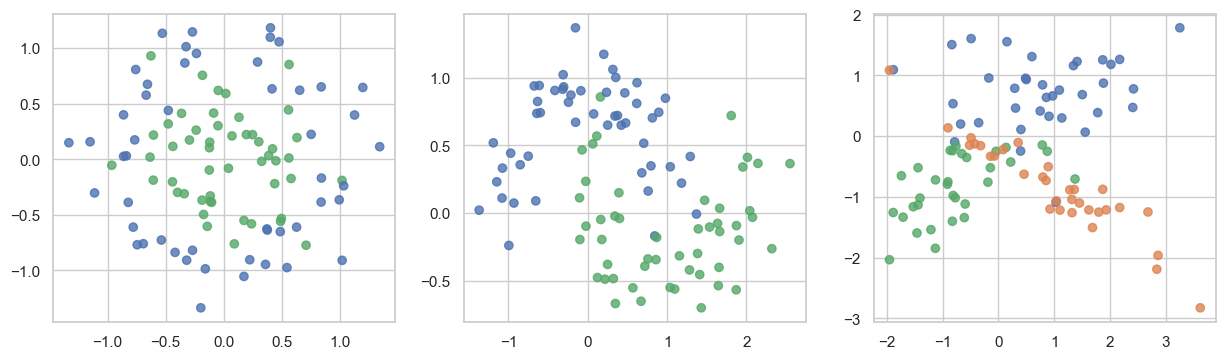

In [14]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [15]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

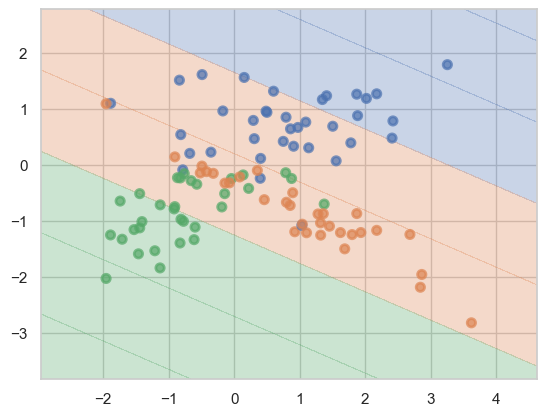

In [16]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

__Ответ:__

Dataset 1: Train accuracy = 1.000, Test accuracy = 0.733
Переобучение: 0.267

Dataset 2: Train accuracy = 1.000, Test accuracy = 0.867
Переобучение: 0.133

Dataset 3: Train accuracy = 1.000, Test accuracy = 0.833
Переобучение: 0.167



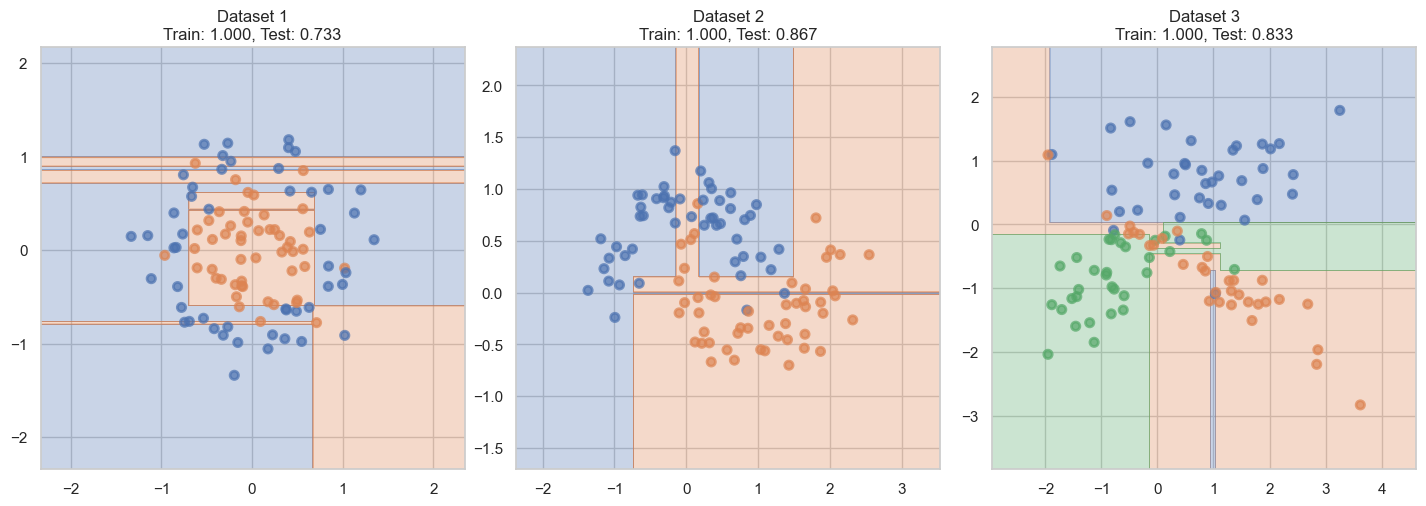

In [17]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 10))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    plt.subplot(2, 3, i + 1)
    plot_surface(clf, X, y)
    plt.title(f'Dataset {i+1}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}')
    
    print(f'Dataset {i+1}: Train accuracy = {train_acc:.3f}, Test accuracy = {test_acc:.3f}')
    print(f'Переобучение: {train_acc - test_acc:.3f}\n')


__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [18]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Ответ:__

Dataset 1, Params {'max_depth': None, 'min_samples_leaf': 1}: Train=1.000, Test=0.733
Dataset 1, Params {'max_depth': 3, 'min_samples_leaf': 1}: Train=0.886, Test=0.733
Dataset 1, Params {'max_depth': 5, 'min_samples_leaf': 1}: Train=0.971, Test=0.767
Dataset 1, Params {'max_depth': None, 'min_samples_leaf': 10}: Train=0.814, Test=0.767


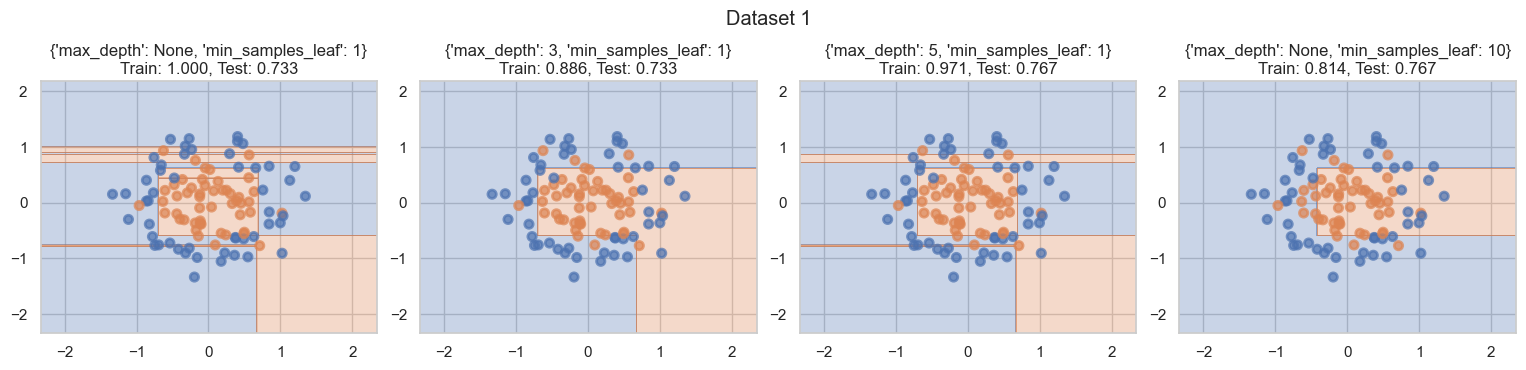

Dataset 2, Params {'max_depth': None, 'min_samples_leaf': 1}: Train=1.000, Test=0.867
Dataset 2, Params {'max_depth': 3, 'min_samples_leaf': 1}: Train=0.914, Test=0.933
Dataset 2, Params {'max_depth': 5, 'min_samples_leaf': 1}: Train=1.000, Test=0.867
Dataset 2, Params {'max_depth': None, 'min_samples_leaf': 10}: Train=0.871, Test=0.767


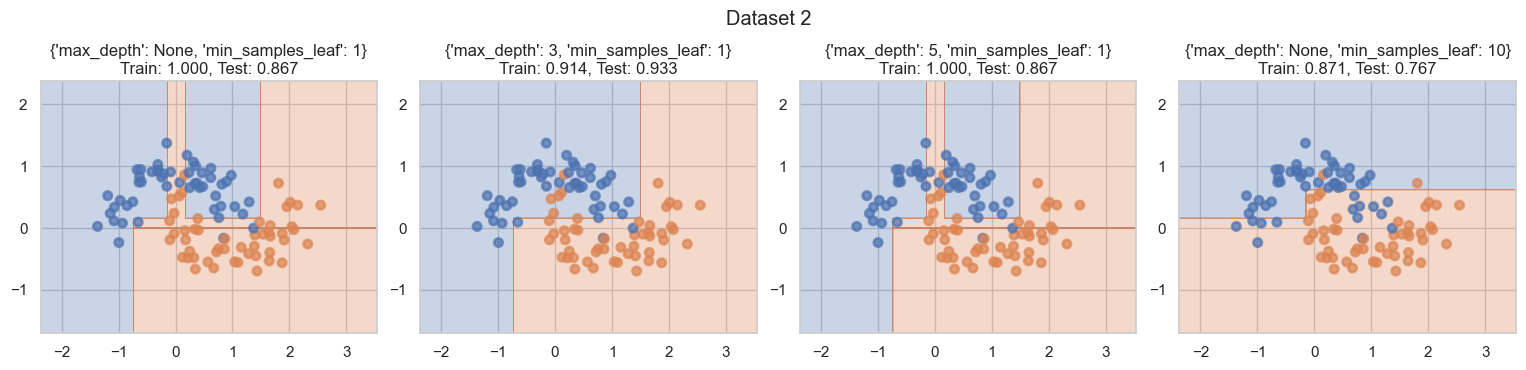

Dataset 3, Params {'max_depth': None, 'min_samples_leaf': 1}: Train=1.000, Test=0.833
Dataset 3, Params {'max_depth': 3, 'min_samples_leaf': 1}: Train=0.943, Test=0.867
Dataset 3, Params {'max_depth': 5, 'min_samples_leaf': 1}: Train=0.971, Test=0.800
Dataset 3, Params {'max_depth': None, 'min_samples_leaf': 10}: Train=0.886, Test=0.767


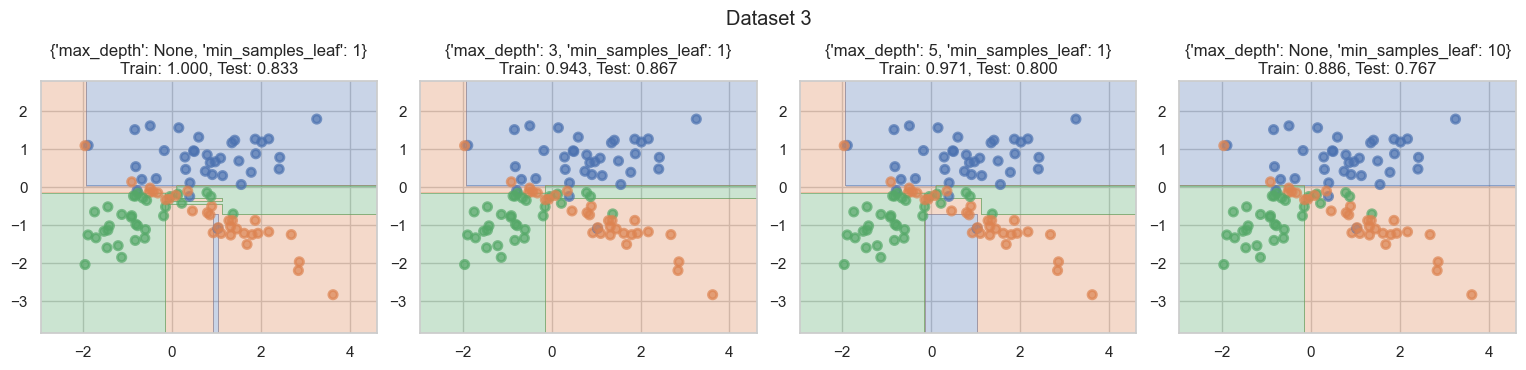

In [19]:
params = [
    {'max_depth': None, 'min_samples_leaf': 1},
    {'max_depth': 3, 'min_samples_leaf': 1},
    {'max_depth': 5, 'min_samples_leaf': 1},
    {'max_depth': None, 'min_samples_leaf': 10}
]

for dataset_idx, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    plt.figure(figsize=(16, 4))
    
    for i, param in enumerate(params):
        clf = DecisionTreeClassifier(random_state=42, **param)
        clf.fit(X_train, y_train)
        
        train_acc = clf.score(X_train, y_train)
        test_acc = clf.score(X_test, y_test)
        
        plt.subplot(1, 4, i + 1)
        plot_surface(clf, X, y)
        plt.title(f'{param}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}')
        
        print(f'Dataset {dataset_idx+1}, Params {param}: Train={train_acc:.3f}, Test={test_acc:.3f}')
    
    plt.suptitle(f'Dataset {dataset_idx + 1}')
    plt.show()


# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

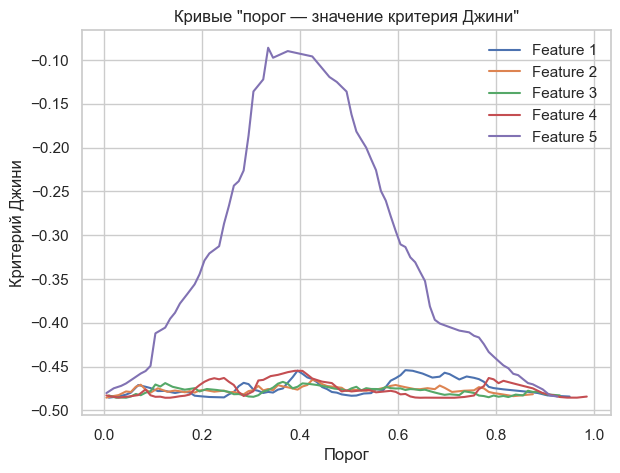

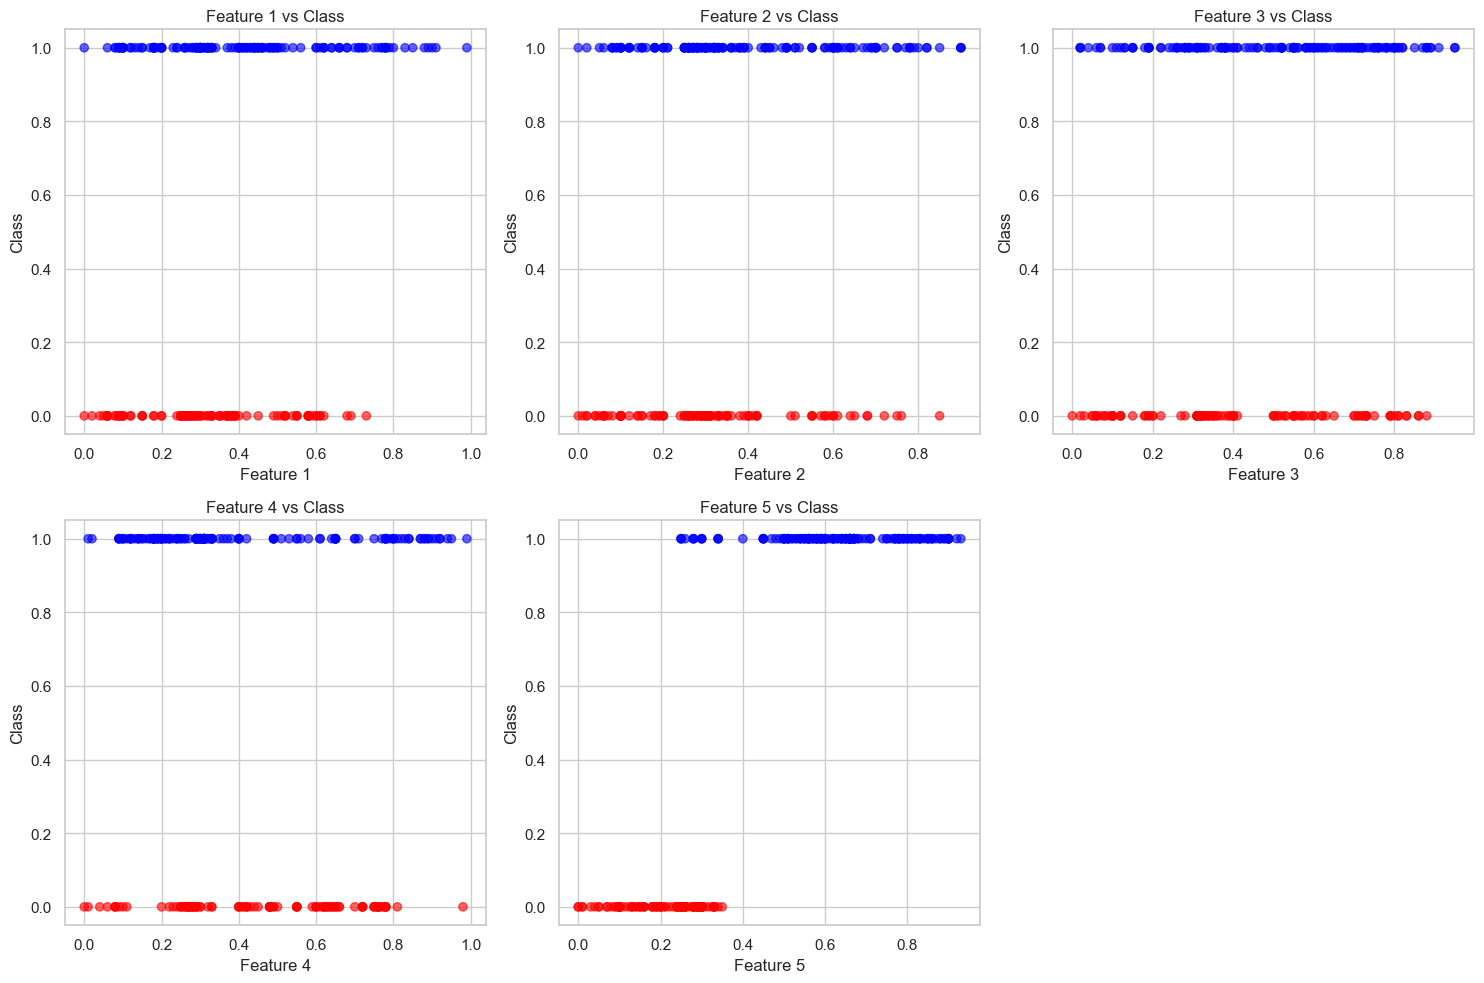

In [20]:

from hw2code import find_best_split

data = pd.read_csv('datasets/students.csv')
X = data.iloc[:, :5].values
y = data.iloc[:, -1].values

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for i in range(5):
    thresholds, ginis, _, _ = find_best_split(X[:, i], y)
    plt.plot(thresholds, ginis, label=f'Feature {i+1}')
plt.xlabel('Порог')
plt.ylabel('Критерий Джини')
plt.title('Кривые "порог — значение критерия Джини"')
plt.legend()
plt.grid(True)

plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    colors = ['red' if label == 0 else 'blue' for label in y]
    plt.scatter(X[:, i], y, c=colors, alpha=0.6)
    plt.xlabel(f'Feature {i+1}')
    plt.ylabel('Class')
    plt.title(f'Feature {i+1} vs Class')
    plt.grid(True)

plt.tight_layout()
plt.show()


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

stg. Да, согласуется со скаттерами. Хорошие признаки - высокий острый пик. Плохие - плоская кривая без пиков, классы не разделяются.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Сделал

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from hw2code import DecisionTree

file_path = 'datasets/agaricus-lepiota.data'
try:
    df = pd.read_csv(file_path, header=None)
except FileNotFoundError:
    print(f"Error: The data file '{file_path}' was not found.")
    print("Please make sure 'agaricus-lepiota.data' is in the same directory as the script.")
    exit()

df_encoded = pd.DataFrame()
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df_encoded.iloc[:, 1:].values
y = df_encoded.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

n_features = X.shape[1]
feature_types = ['categorical'] * n_features

dt = DecisionTree(feature_types=feature_types)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy on the mushroom dataset: {accuracy:.4f}")

if accuracy == 1.0:
    print("Achieved perfect accuracy, as expected!")


Accuracy on the mushroom dataset: 1.0000
Achieved perfect accuracy, as expected!


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

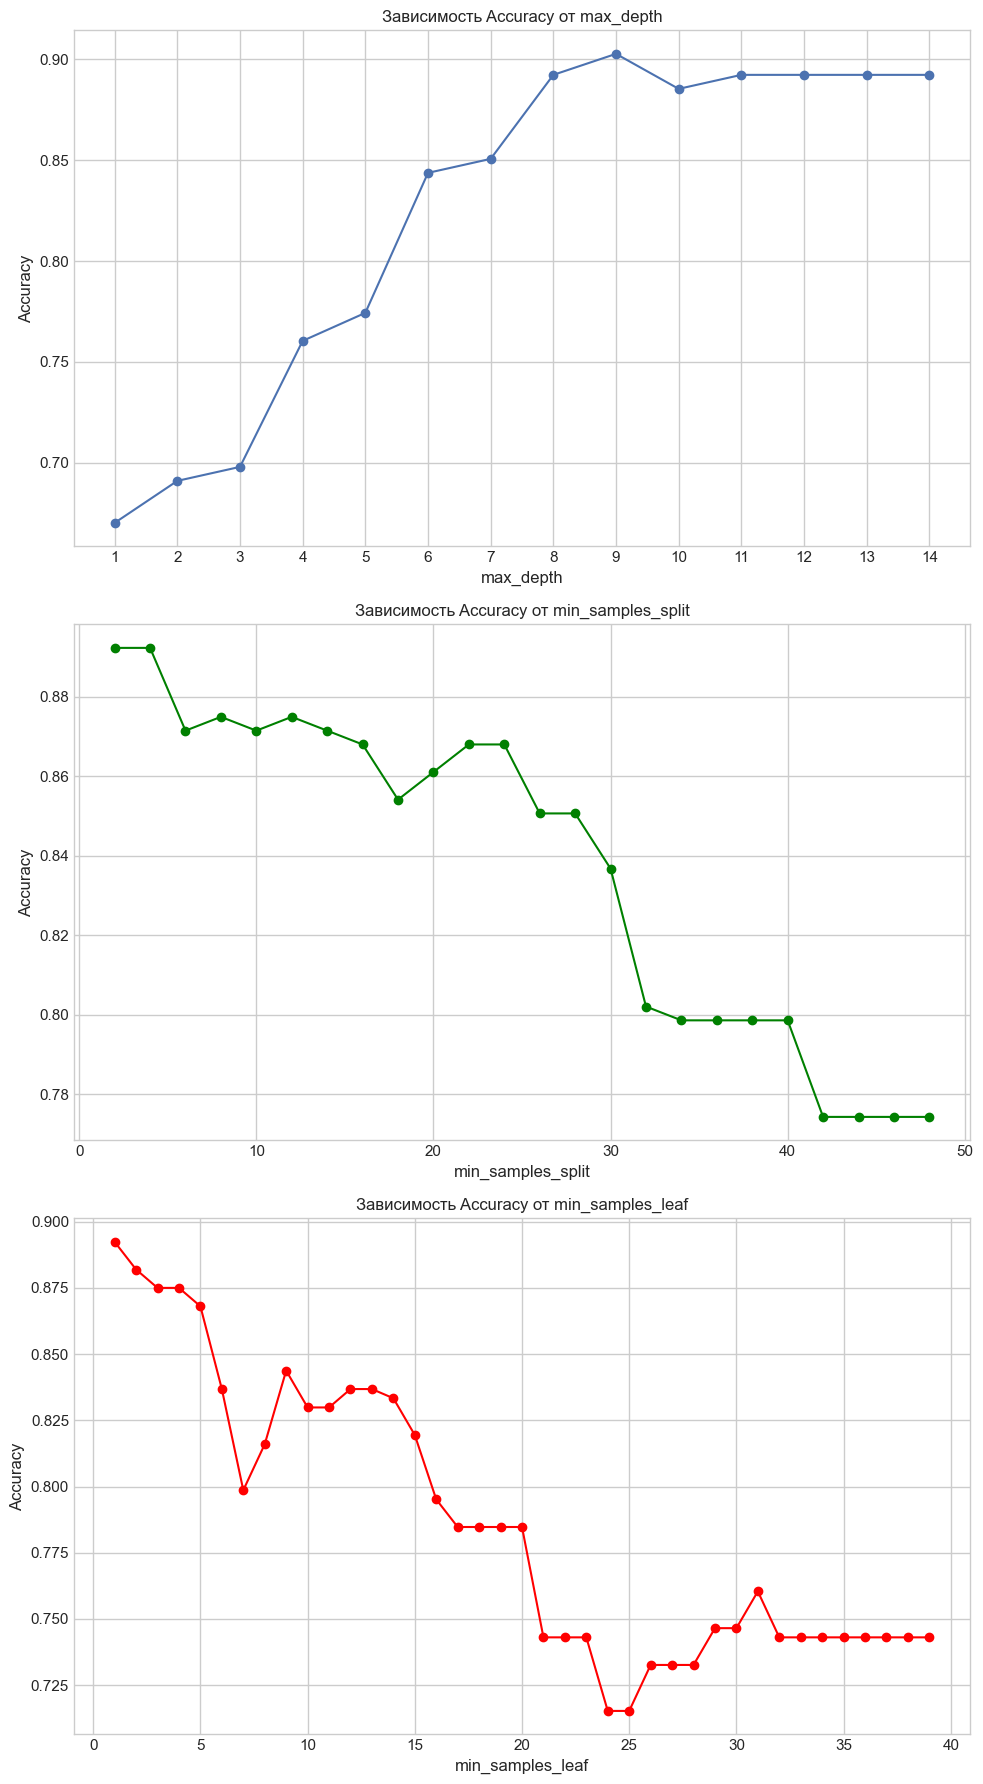

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from hw2code import DecisionTree

try:
    df = pd.read_csv('datasets/tic-tac-toe-endgame.csv', header=None)
except FileNotFoundError:
    print("Ошибка: Файл 'tic-tac-toe-endgame.data' не найден.")
    print("Пожалуйста, скачайте его и поместите в ту же папку, что и скрипт.")
    exit()

df_encoded = pd.DataFrame()
for col in df.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])

X = df_encoded.iloc[:, :-1].values
y = df_encoded.iloc[:, -1].values

feature_types = ['categorical'] * X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

depths = range(1, 15)
accuracies_depth = []

for depth in depths:
    dt = DecisionTree(feature_types=feature_types, max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict(X_test)
    accuracies_depth.append(accuracy_score(y_test, y_pred))

split_sizes = range(2, 50, 2)
accuracies_split = []

for size in split_sizes:
    dt = DecisionTree(feature_types=feature_types, min_samples_split=size)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    accuracies_split.append(accuracy_score(y_test, y_pred))

leaf_sizes = range(1, 40)
accuracies_leaf = []

for size in leaf_sizes:
    dt = DecisionTree(feature_types=feature_types, min_samples_leaf=size)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    accuracies_leaf.append(accuracy_score(y_test, y_pred))

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

axes[0].plot(depths, accuracies_depth, marker='o', linestyle='-')
axes[0].set_title('Зависимость Accuracy от max_depth')
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(depths)

axes[1].plot(split_sizes, accuracies_split, marker='o', linestyle='-', color='green')
axes[1].set_title('Зависимость Accuracy от min_samples_split')
axes[1].set_xlabel('min_samples_split')
axes[1].set_ylabel('Accuracy')

axes[2].plot(leaf_sizes, accuracies_leaf, marker='o', linestyle='-', color='red')
axes[2].set_title('Зависимость Accuracy от min_samples_leaf')
axes[2].set_xlabel('min_samples_leaf')
axes[2].set_ylabel('Accuracy')

fig.tight_layout()
plt.show()


__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [33]:
import pandas as pd
import importlib
import hw2code
importlib.reload(hw2code)
from hw2code import DecisionTree
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os

# Убедитесь, что файл hw2code.py находится в той же директории
from hw2code import DecisionTree

# --- 1. Подготовка данных и моделей ---

# Словарь с информацией о датасетах, пути обновлены
DATASETS = {
    'mushrooms': {
        'path': os.path.join('datasets', 'agaricus-lepiota.data'),
        'target_col': 0,
        'target_map': None
    },
    'tic-tac-toe': {
        'path': os.path.join('datasets', 'tic-tac-toe-endgame.csv'),
        'target_col': -1,
        'target_map': None
    },
    'cars': {
        'path': os.path.join('datasets', 'car.data'),
        'target_col': -1,
        'target_map': lambda y: y.isin(['good', 'vgood']).astype(int)
    },
    'nursery': {
        'path': os.path.join('datasets', 'nursery.data'),
        'target_col': -1,
        'target_map': lambda y: y.isin(['very_recom', 'priority', 'spec_prior']).astype(int)
    }
}

# Словарь для хранения результатов
results = {}

# --- 2. Цикл по датасетам для оценки ---

for name, params in DATASETS.items():
    print(f"--- Обработка датасета: {name} ---")
    
    # Загрузка данных из локального файла
    try:
        df = pd.read_csv(params['path'], header=None)
    except FileNotFoundError:
        print(f"Не удалось найти файл {params['path']}. Убедитесь, что он лежит в папке 'datasets'.")
        continue
    except Exception as e:
        print(f"Не удалось обработать датасет {name}. Ошибка: {e}")
        continue

    # Определение признаков (X) и цели (y)
    if params['target_col'] == 0:
        y_raw = df.iloc[:, 0]
        X_raw = df.iloc[:, 1:]
    else:
        y_raw = df.iloc[:, -1]
        X_raw = df.iloc[:, :-1]

    # Предобработка признаков (LabelEncoder)
    X_le = pd.DataFrame()
    for col in X_raw.columns:
        X_le[col] = LabelEncoder().fit_transform(X_raw[col])
    
    # Предобработка целевой переменной
    if params['target_map']:
        y = params['target_map'](y_raw)
    else:
        y = LabelEncoder().fit_transform(y_raw)

    n_features = X_le.shape[1]
    
    # --- Оценка моделей ---
    
    # 1. Наше дерево, все признаки вещественные
    print("Оценка: DT (real)...")
    dt_real = DecisionTree(feature_types=['real'] * n_features)
    scores_real = cross_val_score(dt_real, X_le.values, y, cv=10, scoring='accuracy')
    
    # 2. Наше дерево, все признаки категориальные
    print("Оценка: DT (categorical)...")
    dt_cat = DecisionTree(feature_types=['categorical'] * n_features)
    scores_cat = cross_val_score(dt_cat, X_le.values, y, cv=10, scoring='accuracy')

    # 3. Наше дерево (real) + One-Hot Encoding
    print("Оценка: DT (real) + OHE...")
    ohe_transformer = ColumnTransformer(
        [('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), list(range(n_features)))],
        remainder='passthrough'
    )
    pipeline_ohe = Pipeline([
        ('encoder', ohe_transformer),
        ('classifier', DecisionTree(feature_types=[]))
    ])
    scores_ohe = cross_val_score(pipeline_ohe, X_le, y, cv=10, scoring='accuracy')

    # 4. DecisionTreeClassifier из sklearn
    print("Оценка: sklearn DT...")
    sklearn_dt = DecisionTreeClassifier(random_state=42)
    scores_sklearn = cross_val_score(sklearn_dt, X_le.values, y, cv=10, scoring='accuracy')
    
    # Сохраняем средние значения точности
    results[name] = {
        'DT (real)': np.mean(scores_real),
        'DT (categorical)': np.mean(scores_cat),
        'DT (real) + OHE': np.mean(scores_ohe),
        'sklearn DT': np.mean(scores_sklearn)
    }
    print("-" * 30 + "\n")

# --- 3. Формирование и вывод итоговой таблицы ---

results_df = pd.DataFrame.from_dict(results, orient='index')
print("Итоговая таблица accuracy (среднее по 10 фолдам):")
print(results_df)


--- Обработка датасета: mushrooms ---
Оценка: DT (real)...
Оценка: DT (categorical)...
Оценка: DT (real) + OHE...
Оценка: sklearn DT...
------------------------------

--- Обработка датасета: tic-tac-toe ---
Оценка: DT (real)...
Оценка: DT (categorical)...
Оценка: DT (real) + OHE...
Оценка: sklearn DT...
------------------------------

--- Обработка датасета: cars ---
Оценка: DT (real)...
Оценка: DT (categorical)...
Оценка: DT (real) + OHE...
Оценка: sklearn DT...
------------------------------

--- Обработка датасета: nursery ---
Оценка: DT (real)...
Оценка: DT (categorical)...
Оценка: DT (real) + OHE...
Оценка: sklearn DT...
------------------------------

Итоговая таблица accuracy (среднее по 10 фолдам):
             DT (real)  DT (categorical)  DT (real) + OHE  sklearn DT
mushrooms     0.999261          0.999261         0.999631    0.960384
tic-tac-toe   0.497083          0.497083         0.595000    0.785351
cars          0.942647          0.942647         0.919495    0.942707
nur

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Ранжирование алгоритмов неодинаково для разных датасетов. На mushrooms и nursery все методы показывают 99% точности из-за четких категориальных правил, на cars результаты схожи (94%), а на tic-tac-toe sklearn значительно превосходит остальные (78% vs 50-60%). Это происходит потому что sklearn использует продвинутые критерии разбиения и pruning, а моя реализация - базовый Gini. OHE помогает на tic-tac-toe, создавая более четкие границы для категориальных признаков. Случайность присутствует в разбиении на фолды и порядке обработки признаков при равных Gini. Можно улучшить результаты фиксацией random_state, добавлением обрезки дерева, настройкой гиперпараметров и использованием более сложных критериев разбиения.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [ ]:
Люти кайф